In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fedot_ind.core.architecture.experiment.TimeSeriesClassifier import TimeSeriesClassifier
from fedot_ind.core.architecture.pipelines.classification import ClassificationPipelines
from fedot_ind.core.architecture.postprocessing.Analyzer import PerformanceAnalyzer
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from sklearn.metrics import classification_report
from fedot_ind.core.operation.optimization.FeatureSpace import VarianceSelector

Create support fucntions for visualisation and result of experiment analysis

In [3]:
metric_name = 'f1'
models_name = ['statistical', 'topological','spectral']
SOTA_results = [0.788201919, 0.744594487, 0.818165359, 0.794619584, 0.806207058,
                0.7286329, 0.781281546, 0.70060504, 0.680166882,
                0.671386013, 0.71358025, 0.694936093, 0.681765546, 0.62167202]
SOTA_model_names = ['TS-CHIEF',
                    'HIVE-COTE v1.0',
                    'InceptionTime',
                    'ROCKET',
                    'ResNet',
                    'STC'
                    'ProximityForest',
                    'WEASEL',
                    'S-BOSS',
                    'BOSS',
                    'cBOSS',
                    'TSFRISE',
                    'Catch22',
]
SOTA_dict = {k:v for k,v in zip(SOTA_model_names,SOTA_results)}

def compare_results(sota_dict, current_results):
    counter = 0
    for SOTA_model in sota_dict.keys():
        diff = current_results - sota_dict[SOTA_model]
        if diff > 0:
            print(f'FEDOT_TSC better than {SOTA_model} by {round(abs(diff*100))} %')
            counter += 1
        else:
            print(f'FEDOT_TSC worse than {SOTA_model} by {round(abs(diff*100))} %')
    print(f'FEDOT_TSC better than - {round((counter/13)*100)} % SOTA models')

def plot_sample_by_class(samples, labels, mode: str = None):
    if mode is None:
        df = samples
    else:
        df = pd.DataFrame([x[mode].values for x in samples])
    df = df.set_index(labels)
    temp_df = pd.DataFrame()
    for label in np.unique(labels):
        temp_df[f'Meadian_TS. Class -{label}'] = df[df.index == label].median()
    temp_df.plot(figsize=(15, 10))
    plt.show()

def get_results(model, features, target):
    labels = model.predict(test_features=features)
    probs = model.predict_proba(test_features=features)
    metrics = PerformanceAnalyzer().calculate_metrics(target=target,
                                                      predicted_labels=labels['label'],
                                                      predicted_probs=probs['class_probability'])

    return metrics

Prepare data for experiment

In [4]:
dataset_name = 'Lightning7'
train, test = DataLoader(dataset_name).load_data()

2023-03-13 13:28:56,732 - DataLoader - Trying to read Lightning7 data locally
2023-03-13 13:28:56,732 - DataLoader - Trying to read Lightning7 data locally


Initialize Fedot and Industrial models hyperparams

In [5]:
model_hyperparams = {
        'problem': 'classification',
        'seed': 42,
        'timeout': 4,
        'max_depth': 6,
        'max_arity': 3,
        'cv_folds': 3,
        'logging_level': 20,
        'n_jobs': 4
}
feature_hyperparams = {
        'window_mode': True,
        'window_size': 10
    }
dict_result = {}

Initilize Industrial time series classification pipelines

In [6]:
pipeline_cls = ClassificationPipelines(train_data=train, test_data=test)

Experiment with Statistical feature generator pipeline

In [7]:
model_stats, prediction_stats = pipeline_cls('SpecifiedFeatureGeneratorTSC')(feature_generator_type='statistical',
                                                                              model_hyperparams=model_hyperparams,
                                                                              feature_hyperparams=feature_hyperparams)

2023-03-13 13:29:11,655 - Fitting model...
2023-03-13 13:29:11,655 - Fitting model...


2023-03-13 13:29:11 - [root] - INFO |  Fitting model...


IndexError: index 1 is out of bounds for axis 0 with size 1

Experiment with Topological feature generator pipeline

In [8]:
model_topological, prediction_topological = pipeline_cls('DataDrivenTSC')(feature_generator_type='topological',
                                                                              model_hyperparams=model_hyperparams,
                                                                              feature_hyperparams=feature_hyperparams)

KeyError: 'data_driven_hyperparams'

Experiment with DataDriven(spectral) feature generator pipeline

In [9]:
model_data_driven, prediction_data_driven = pipeline_cls('DataDrivenTSC')(component=0,
                                                                            model_hyperparams=model_hyperparams,
                                                                            feature_hyperparams=feature_hyperparams)



KeyError: 'data_driven_hyperparams'

Let's plot "median time series representation" of each class.

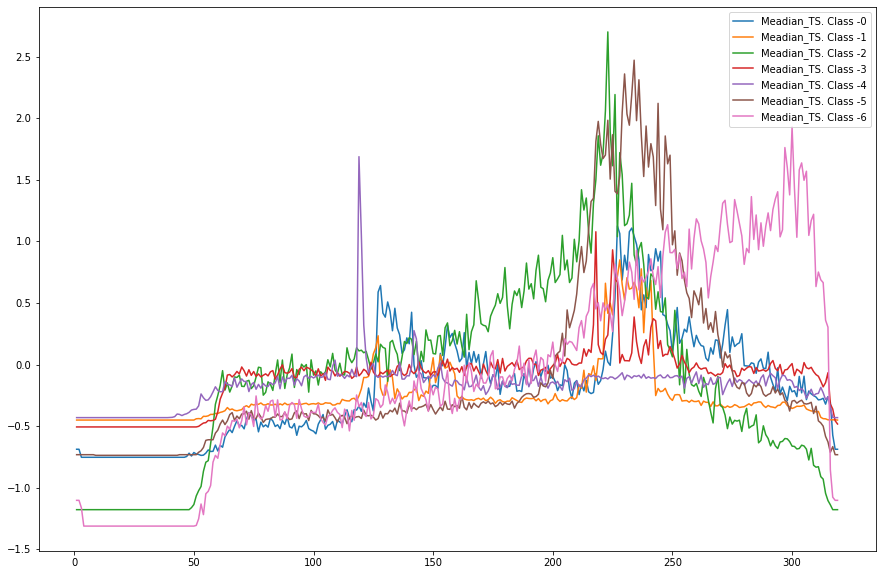

In [9]:
plot_sample_by_class(train[0], train_target)

Create TSC (Time Series Classification) model

In [10]:
basic_ts_clf_class = TimeSeriesClassifier(model_hyperparams={
        'problem': 'classification',
        'seed': 42,
        'timeout': 1,
        'max_depth': 4,
        'max_arity': 2,
        'cv_folds': 2,
        'logging_level': 50,
        'n_jobs': 2
    })

As a baseline, we will use a model based on statistical features of time series.
We will not use any additional transformations such as smoothing or sliding windows.

In [11]:
quantile_model_basic = StatsRunner(window_mode=False)
train_feats_baseline = quantile_model_basic.get_features(train[0], dataset_name)
test_feats_baseline = quantile_model_basic.get_features(test[0], dataset_name)

2023-01-12 16:12:33 - INFO - Number of TS to be processed: 70
2023-01-12 16:12:33 - INFO - Time spent on feature generation - 0.09 sec
2023-01-12 16:12:33 - INFO - Number of TS to be processed: 73
2023-01-12 16:12:33 - INFO - Time spent on feature generation - 0.1 sec


As a more complex model, we will use a model based on spectral features of time series.
An advanced version of this model allows you to reduce the dimension
of the feature space by grouping the PCT (principal component trajectory) among themselves.

In [14]:
spectral_model_basic = SSARunner(window_mode=False,
                                     window_sizes={dataset_name: [30]},
                                     spectral_hyperparams={'combine_eigenvectors': False,
                                                           'correlation_level': 0.8})
train_feats_spectral_basic = spectral_model_basic.get_features(train[0], dataset_name)
test_feats_spectral_basic = spectral_model_basic.get_features(test[0], dataset_name)
train_eigenvectors_spectral_basic = spectral_model_basic.eigenvectors_list_train

2023-01-12 16:14:44 - INFO - Generate features for window length - 30
2023-01-12 16:14:44 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 35/35 [00:01<00:00, 19.15 ts/s]
2023-01-12 16:14:46 - INFO - Number of time series processed: 35
2023-01-12 16:14:46 - INFO - Every eigenvector with impact less then 1 % percent was eliminated. 48 % of explained dispersion obtained by first - 4 components.
2023-01-12 16:14:46 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 70/70 [00:01<00:00, 39.25 ts/s]
2023-01-12 16:14:48 - INFO - Number of time series processed: 70
2023-01-12 16:14:49 - INFO - Window length = 30 was chosen
2023-01-12 16:14:49 - INFO - Time spent on feature generation - 4.78 sec
2023-01-12 16:14:49 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 73/73 [00:02<00:00, 35.32 ts/s]
2023-01-12 16:14:51 - INFO - Number of time series processed: 73
2023-01-12 16:14:52 - INFO - Time spen

In [15]:
model_features = {'spectral_basic':train_feats_spectral_basic,
                  'quantile':train_feats_baseline}
strategy = VarianceSelector(models=model_features)
best_feature = strategy.get_best_model()


Let's plot first 3 samples decomposed into PCT

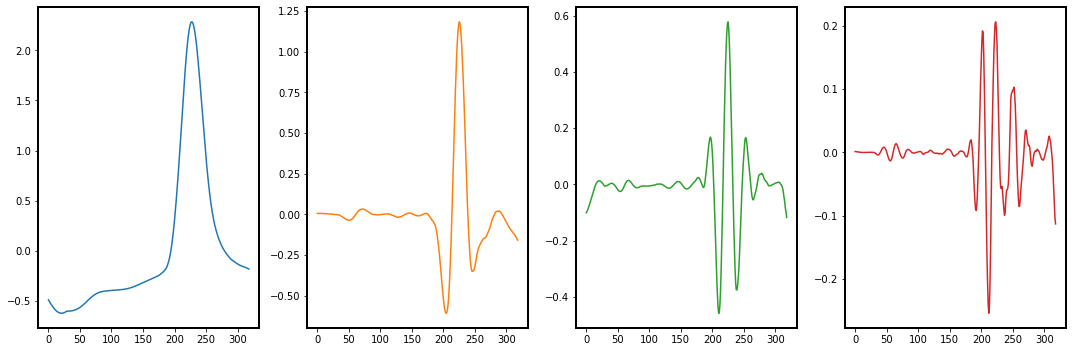

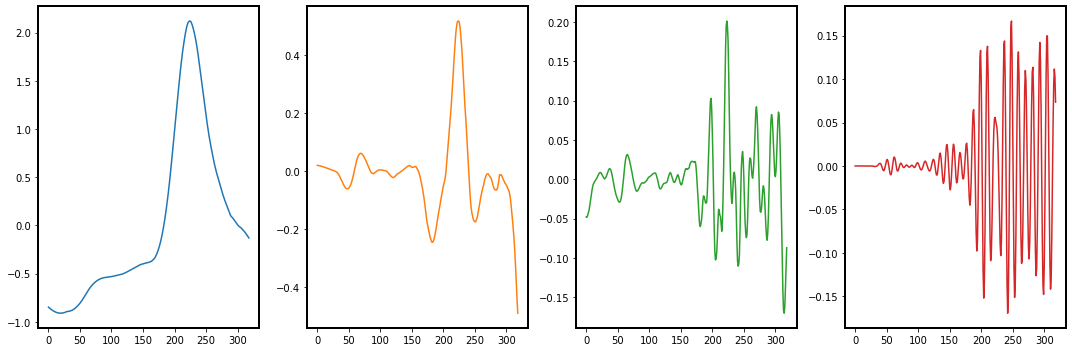

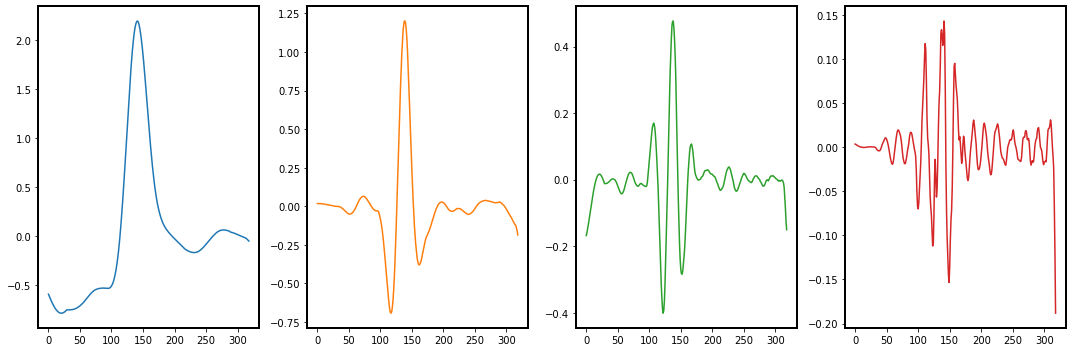

In [103]:
spectral_model_basic.visualise(train_eigenvectors_spectral_basic[:3])

Let's plot median of first PCT

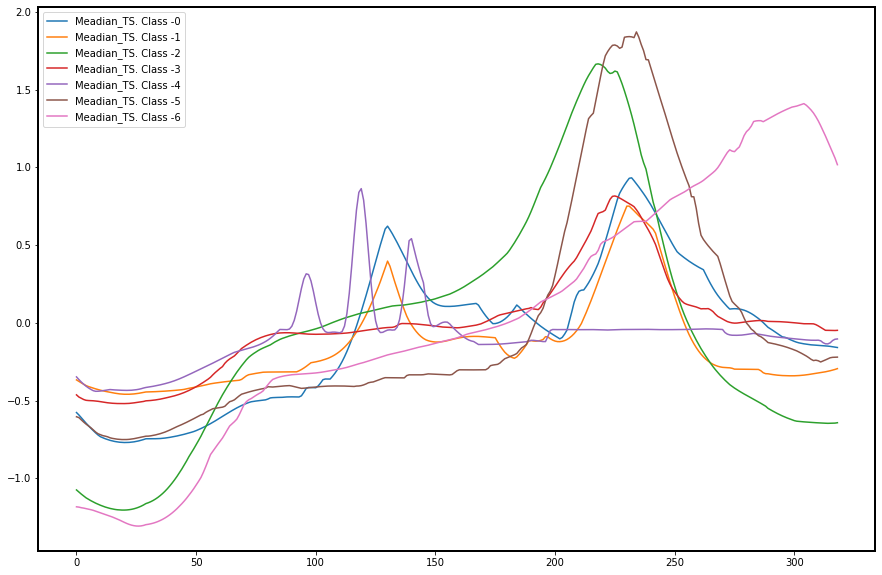

In [104]:
plot_sample_by_class(train_eigenvectors_spectral_basic,train_target,mode='F0')

Let's plot median of second PCT

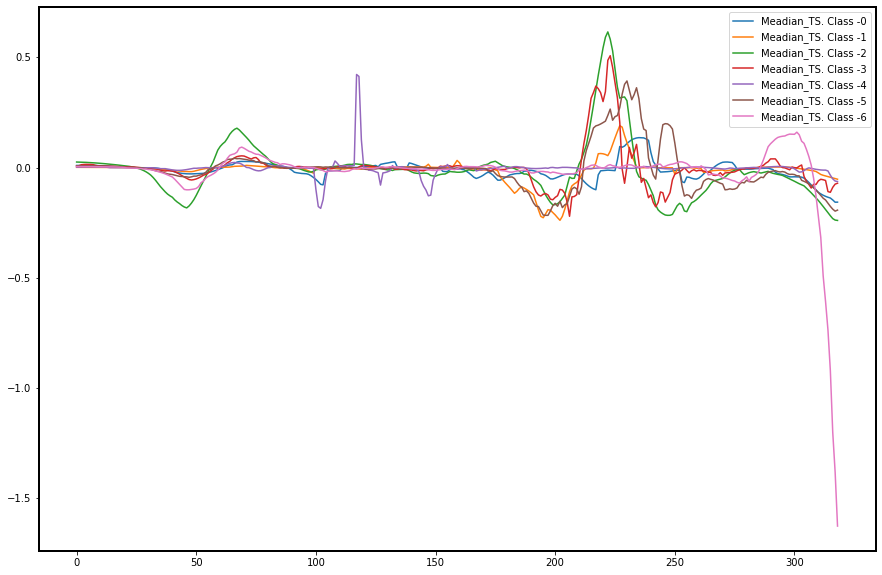

In [105]:
plot_sample_by_class(train_eigenvectors_spectral_basic,train_target,mode='F1')

In [13]:
spectral_model_advanced = SSARunner(window_mode=False,
                                        window_sizes={dataset_name: [30]},
                                        spectral_hyperparams={'combine_eigenvectors': True,
                                                              'correlation_level': 0.8})
train_feats_advanced = spectral_model_advanced.get_features(train[0], dataset_name)
test_feats_advanced = spectral_model_advanced.get_features(test[0], dataset_name)
train_eigenvectors_advanced = spectral_model_advanced.eigenvectors_list_train

2023-01-12 16:14:39 - INFO - Generate features for window length - 30
2023-01-12 16:14:39 - INFO - Number of processes: 4
Feature Generation. TS processed:   0%|          | 0/35 [00:01<?, ? ts/s]


TypeError: combine_eigenvectors() missing 2 required positional arguments: 'ts_length' and 'subseq_length'

Let's plot first 3 samples decomposed into PCT (principal component trajectory)

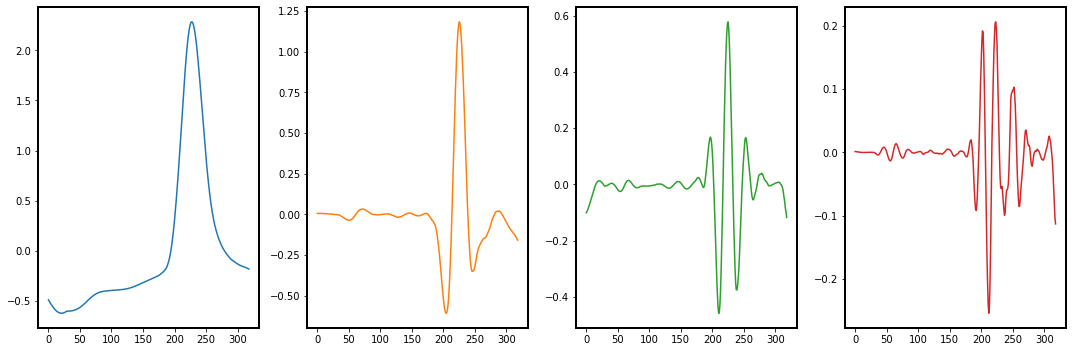

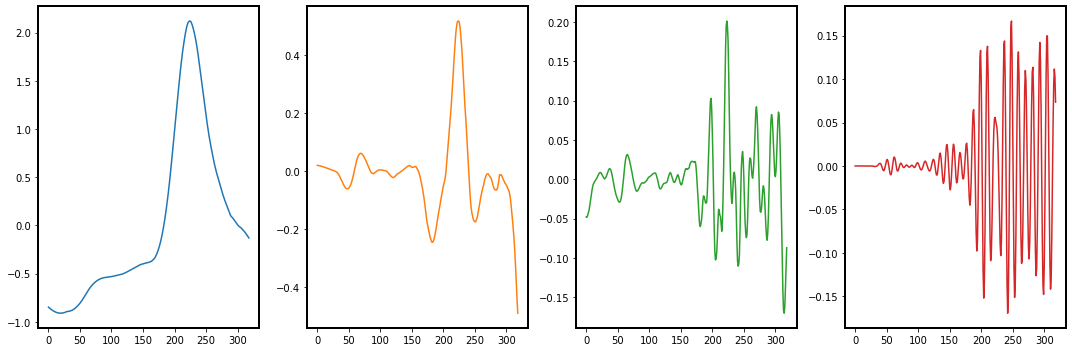

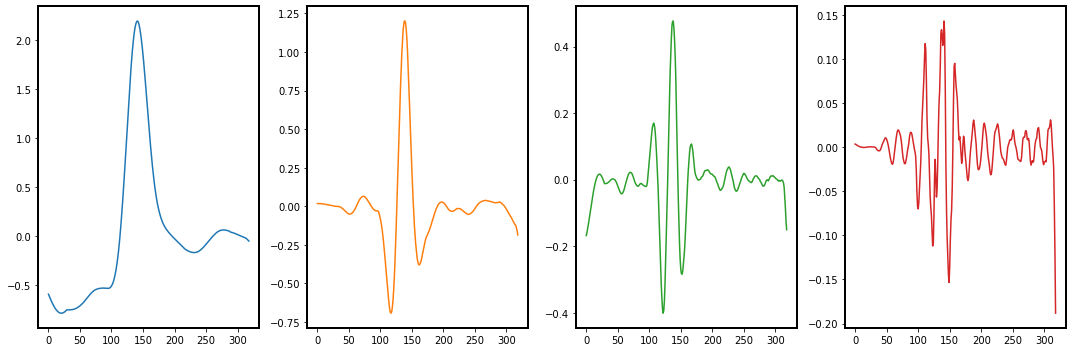

In [107]:
spectral_model_basic.visualise(train_eigenvectors_advanced[:3])

Let's plot median of first PCT

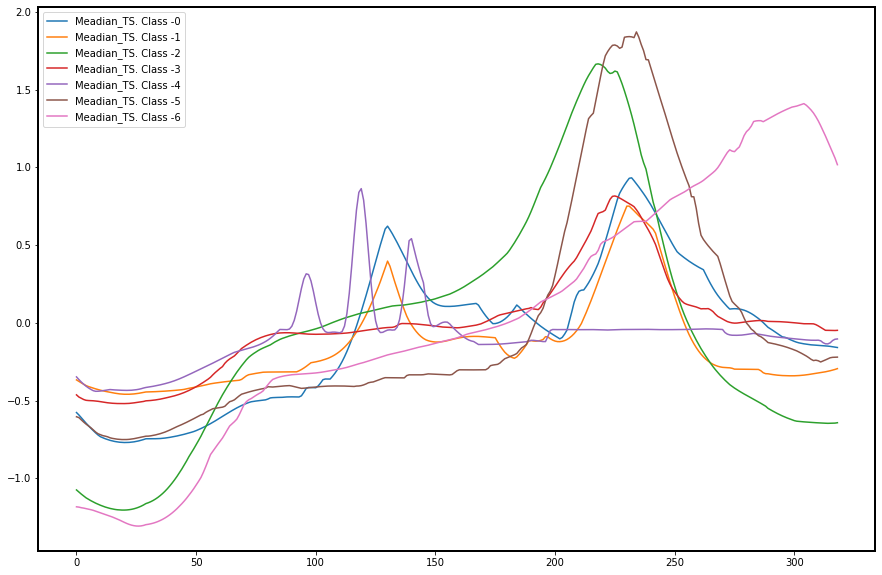

In [108]:
plot_sample_by_class(train_eigenvectors_advanced,train_target,mode=0)

Let's plot median of second PCT

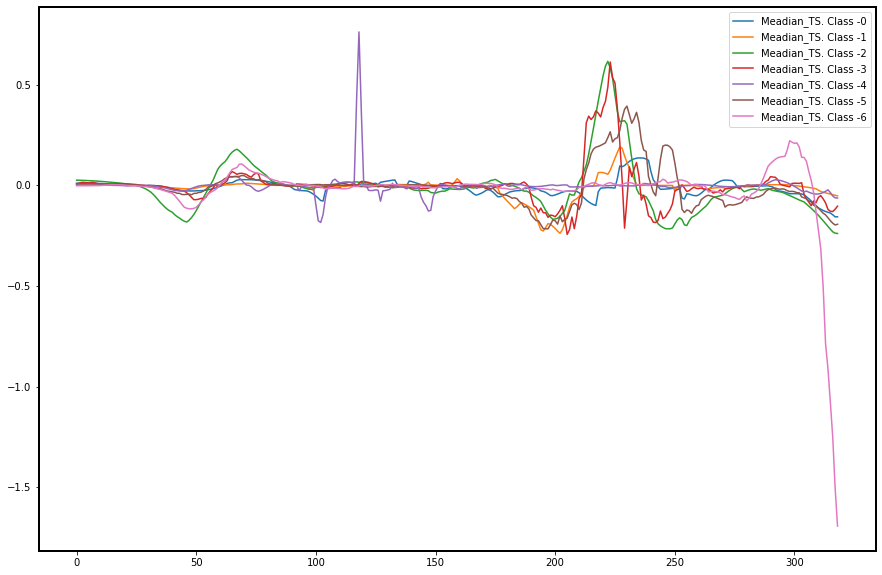

In [109]:
plot_sample_by_class(train_eigenvectors_advanced,train_target,mode=1)

In [111]:
IndustrialModelBaseline = basic_ts_clf_class.fit(train_features=train_feats_baseline, train_target=train_target)[0]
baseline_results = get_results(basic_ts_clf_class, test_feats_baseline, test_target)
predict_baseline = basic_ts_clf_class.predict(test_feats_baseline)['label']

2022-12-20 18:20:05 - INFO - START TRAINING


2022-12-20 18:20:05,658 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2022-12-20 18:20:05,662 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-12-20 18:20:05,664 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 18:20:39,218 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:33<?, ?gen/s]

2022-12-20 18:20:39,221 - ApiComposer - Hyperparameters tuning started with 0 min. timeout


  0%|          | 61/100000 [00:26<11:54:43,  2.33trial/s, best loss: -0.8977010000000001]
2022-12-20 18:21:06,234 - ApiComposer - Hyperparameters tuning finished
2022-12-20 18:21:06,362 - ApiComposer - Model generation finished
2022-12-20 18:21:06,560 - FEDOT logger - Final pipeline was fitted
2022-12-20 18:21:06,560 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rf, isolation_forest_class]}


In [112]:
baseline_results

{'roc_auc': 0.904,
 'f1': 0.549,
 'precision': 0.616,
 'accuracy': 0.562,
 'logloss': 1.107}

In [128]:
compare_results(sota_dict=SOTA_dict,current_results=baseline_results[metric_name])

FEDOT_TSC worse than TS-CHIEF by 24 %
FEDOT_TSC worse than HIVE-COTE v1.0 by 20 %
FEDOT_TSC worse than InceptionTime by 27 %
FEDOT_TSC worse than ROCKET by 25 %
FEDOT_TSC worse than ResNet by 26 %
FEDOT_TSC worse than STCProximityForest by 18 %
FEDOT_TSC worse than WEASEL by 23 %
FEDOT_TSC worse than S-BOSS by 15 %
FEDOT_TSC worse than BOSS by 13 %
FEDOT_TSC worse than cBOSS by 12 %
FEDOT_TSC worse than TSFRISE by 16 %
FEDOT_TSC worse than Catch22 by 15 %
FEDOT_TSC better than - 0 % SOTA models


In [114]:
IndustrialModelSpectral = basic_ts_clf_class.fit(train_features=train_feats_spectral_basic, train_target=train_target)[0]
basic_result = get_results(basic_ts_clf_class, test_feats_spectral_basic, test_target)
predict_basic = basic_ts_clf_class.predict(test_feats_spectral_basic)['label']

2022-12-20 18:21:06 - INFO - START TRAINING


2022-12-20 18:21:06,896 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2022-12-20 18:21:06,900 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-12-20 18:21:06,902 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 18:21:42,876 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:35<?, ?gen/s]

2022-12-20 18:21:42,879 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
  0%|          | 2/100000 [00:00<1:37:12, 17.14trial/s, best loss: -0.9261440000000001]

  0%|          | 372/100000 [00:23<1:42:43, 16.16trial/s, best loss: -0.9301360000000001]
2022-12-20 18:22:06,018 - ApiComposer - Hyperparameters tuning finished
2022-12-20 18:22:06,147 - ApiComposer - Model generation finished
2022-12-20 18:22:06,174 - FEDOT logger - Final pipeline was fitted
2022-12-20 18:22:06,175 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [logit, normalization]}


In [115]:
basic_result

{'roc_auc': 0.944,
 'f1': 0.679,
 'precision': 0.716,
 'accuracy': 0.671,
 'logloss': 0.894}

In [127]:
print(f'Quality metric gain - {round((basic_result[metric_name]-baseline_results[metric_name])*100)} %')

Quality metric gain - 13 %


In [126]:
compare_results(sota_dict=SOTA_dict,current_results=basic_result[metric_name])

FEDOT_TSC worse than TS-CHIEF by 11 %
FEDOT_TSC worse than HIVE-COTE v1.0 by 7 %
FEDOT_TSC worse than InceptionTime by 14 %
FEDOT_TSC worse than ROCKET by 12 %
FEDOT_TSC worse than ResNet by 13 %
FEDOT_TSC worse than STCProximityForest by 5 %
FEDOT_TSC worse than WEASEL by 10 %
FEDOT_TSC worse than S-BOSS by 2 %
FEDOT_TSC worse than BOSS by 0 %
FEDOT_TSC better than cBOSS by 1 %
FEDOT_TSC worse than TSFRISE by 3 %
FEDOT_TSC worse than Catch22 by 2 %
FEDOT_TSC better than - 8 % SOTA models


In [118]:
IndustrialModelSpectralAdvanced = basic_ts_clf_class.fit(train_features=train_feats_advanced, train_target=train_target)[0]
advanced_result = get_results(basic_ts_clf_class, test_feats_advanced, test_target)
predict_advanced = basic_ts_clf_class.predict(test_feats_advanced)['label']

2022-12-20 18:22:06 - INFO - START TRAINING


2022-12-20 18:22:06,562 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2022-12-20 18:22:06,566 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set of candidate models: ['bernb', 'dt', 'knn', 'lgbm', 'logit', 'mlp', 'qda', 'rf', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'isolation_forest_class', 'resample']
2022-12-20 18:22:06,567 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 18:22:40,982 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [00:34<?, ?gen/s]

2022-12-20 18:22:40,985 - ApiComposer - Hyperparameters tuning started with 0 min. timeout


  0%|          | 116/100000 [00:25<5:59:59,  4.62trial/s, best loss: -0.9288803333333333]
2022-12-20 18:23:06,555 - ApiComposer - Hyperparameters tuning finished
2022-12-20 18:23:06,675 - ApiComposer - Model generation finished
2022-12-20 18:23:06,792 - FEDOT logger - Final pipeline was fitted
2022-12-20 18:23:06,793 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rf]}


In [119]:
advanced_result

{'roc_auc': 0.958,
 'f1': 0.723,
 'precision': 0.776,
 'accuracy': 0.726,
 'logloss': 0.814}

In [120]:
print(f'Quality metric gain - {round((advanced_result[metric_name]-basic_result[metric_name])*100)} %')

Quality metric gain - 4 %


In [129]:
compare_results(sota_dict=SOTA_dict,current_results=advanced_result[metric_name])

FEDOT_TSC worse than TS-CHIEF by 7 %
FEDOT_TSC worse than HIVE-COTE v1.0 by 2 %
FEDOT_TSC worse than InceptionTime by 10 %
FEDOT_TSC worse than ROCKET by 7 %
FEDOT_TSC worse than ResNet by 8 %
FEDOT_TSC worse than STCProximityForest by 1 %
FEDOT_TSC worse than WEASEL by 6 %
FEDOT_TSC better than S-BOSS by 2 %
FEDOT_TSC better than BOSS by 4 %
FEDOT_TSC better than cBOSS by 5 %
FEDOT_TSC better than TSFRISE by 1 %
FEDOT_TSC better than Catch22 by 3 %
FEDOT_TSC better than - 38 % SOTA models


In [122]:
for predict,model_name in zip([predict_baseline,predict_basic,predict_advanced],models_name):
    print(f'Confusion Matrix for model - {model_name}')
    print(classification_report(test_target, predict))


Confusion Matrix for model - Statistical
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.67      0.22      0.33         9
           2       0.40      0.67      0.50         6
           3       0.37      1.00      0.54         7
           4       1.00      0.30      0.46        10
           5       0.70      0.74      0.72        19
           6       0.80      0.67      0.73        12

    accuracy                           0.56        73
   macro avg       0.62      0.56      0.52        73
weighted avg       0.65      0.56      0.55        73

Confusion Matrix for model - BaseSpectral
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.40      0.44      0.42         9
           2       0.75      0.50      0.60         6
           3       0.50      1.00      0.67         7
           4       0.88      0.70      0.78      